In [33]:
import os, random
from pathlib import Path
from collections import Counter

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import kagglehub

# --- Cihaz ve seed ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### 📦 Importing Libraries & Setting the Environment

In this section, we import the core Python libraries and deep learning frameworks that will be used throughout the project.  
- **os, random, pathlib, collections** – for file system handling, path management, and simple counting tasks.  
- **NumPy & PyTorch** – the main scientific computing and deep learning framework we will use.  
- **torchvision** – provides tools for image loading, transformations, and pre-trained models.  
- **scikit-learn (train_test_split)** – for splitting our dataset into training/validation/test sets.  
- **kagglehub** – to easily download the dataset from Kaggle.  

Additionally, we set a **random seed (42)** for reproducibility. This ensures that training results remain consistent across runs.  
Finally, we check if a **GPU (CUDA)** is available and set the `device` variable accordingly.

In [34]:
# Dataset'i indir ve kök klasörü bul
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
print("Dataset path:", path)

# Bazı paketlerde 'images/images' gibi çift katman oluyor; aşağıdaki mantıkla kökü akıllıca seçiyoruz
candidates = [
    Path(path) / "images" / "images",
    Path(path) / "images",
    Path(path),
]

DATA_ROOT = None
for c in candidates:
    if c.exists() and any(d.is_dir() for d in c.iterdir()):
        # içinde klasör olan ilk mantıklı kökü seç
        DATA_ROOT = c
        break

if DATA_ROOT is None:
    raise FileNotFoundError(f"Görsel kökü bulunamadı: {path}")

print("DATA_ROOT:", DATA_ROOT)

# Olası sınıf klasörlerine bir göz atalım
class_dirs = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
print("Tahmini sınıf klasörü sayısı:", len(class_dirs))
print("Örnek sınıflar:", class_dirs[:10])


Dataset path: /kaggle/input/recyclable-and-household-waste-classification
DATA_ROOT: /kaggle/input/recyclable-and-household-waste-classification/images/images
Tahmini sınıf klasörü sayısı: 30
Örnek sınıflar: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste']


### 📂 Dataset Download and Directory Setup

In this step, we download the dataset directly from **KaggleHub** and locate the correct image root directory.  
Since some Kaggle datasets may contain multiple nested `images/` folders, we automatically search for the correct directory that contains the class subfolders.

- **Download**: The dataset `"recyclable-and-household-waste-classification"` is downloaded.  
- **Root detection**: We check multiple possible directory structures (`images/images`, `images/`, etc.) to ensure we load the right one.  
- **Class directories**: Once the root is found, we list all subdirectories which represent the different waste categories (30 in total).  

Example classes include: *aerosol_cans, aluminum_food_cans, cardboard_boxes, clothing, coffee_grounds,* etc.


In [36]:
IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.10, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Sadece .png (ve .PNG) dosyaları dahil
png_only = lambda p: str(p).lower().endswith(".png")


### 🖼️ Data Augmentation and Preprocessing

Before training our CNN model, we define a set of **image transformations** to improve generalization and prevent overfitting:

- **Resize / CenterCrop** – Ensures all images have a consistent input size (`224×224`).
- **RandomResizedCrop** – Randomly crops and scales images to simulate different zoom levels.
- **RandomHorizontalFlip** – Flips images horizontally to introduce variation.
- **RandomRotation** – Adds rotation-based augmentation.
- **ColorJitter** – Slightly changes brightness, contrast, saturation, and hue to make the model more robust.
- **ToTensor** – Converts images to PyTorch tensors.
- **Normalize** – Normalizes pixel values using ImageNet mean & standard deviation.

We create two pipelines:
- `train_tf` – with strong augmentations (crop, flip, rotation, color jitter).
- `eval_tf` – simpler pipeline for validation and testing (just resize, crop, normalize).

We also define a filter to include only **.png / .PNG** files.


In [37]:
full_ds = datasets.ImageFolder(
    root=str(DATA_ROOT),
    transform=None,                 # transform'u split sonrası set edeceğiz
    is_valid_file=png_only          # .png/.PNG
)

num_classes = len(full_ds.classes)
print(f"Sınıf sayısı: {num_classes}")
print("İlk 10 sınıf adı:", full_ds.classes[:10])
print("Toplam görüntü:", len(full_ds.samples))


Sınıf sayısı: 30
İlk 10 sınıf adı: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste']
Toplam görüntü: 15000


### 📥 Loading the Dataset with `ImageFolder`

We load the entire dataset using PyTorch's **`ImageFolder`** class, which automatically:
- Reads each subfolder as a separate class.
- Assigns numeric labels to class names.

Key points:
- `root` points to the dataset directory.
- `transform=None` here because we will apply different transforms after splitting.
- `is_valid_file=png_only` ensures only `.png` images are included.

We print:
- Total number of classes (30).
- Example class names.
- Total number of images available in the dataset.


In [38]:
indices = np.arange(len(full_ds))
targets = np.array(full_ds.targets)

# 70% train, 30% temp
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    stratify=targets,
    random_state=SEED,
    shuffle=True
)

# temp'i 15/15 olarak ikiye böl (val/test)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,  # 0.5 of 30% = 15%
    stratify=targets[temp_idx],
    random_state=SEED,
    shuffle=True
)

print(f"Split -> train: {len(train_idx)}  val: {len(val_idx)}  test: {len(test_idx)}")


Split -> train: 10500  val: 2250  test: 2250


### ✂️ Splitting the Dataset into Train / Validation / Test Sets

We split the dataset into **training, validation, and test sets** in two steps:

1. **Initial split:**  
   - 80% training  
   - 20% temporary set (to later split into validation and test)

2. **Validation/Test split:**  
   - From the temporary 20%, we split 50%-50% → **10% validation** and **10% test** overall.

Key details:
- We use `train_test_split` from scikit-learn.
- `stratify=targets` keeps the class distribution balanced across all splits.
- A fixed random seed ensures reproducibility.


In [39]:
from PIL import Image

class TransformSubset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base = base_dataset
        self.indices = list(indices)
        self.transform = transform
        # ImageFolder metadataları:
        self.classes = base_dataset.classes
        self.class_to_idx = base_dataset.class_to_idx

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        real_idx = self.indices[i]
        path, target = self.base.samples[real_idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, target

train_ds = TransformSubset(full_ds, train_idx, train_tf)
val_ds   = TransformSubset(full_ds, val_idx,   eval_tf)
test_ds  = TransformSubset(full_ds, test_idx,  eval_tf)

BATCH_SIZE = 64
NUM_WORKERS = 0  # Kaggle'da genelde 2-4 iyi çalışır

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Dataloader'lar hazır.")


Dataloader'lar hazır.


### 🛠️ Custom Dataset Wrapper & DataLoader Creation

We create a **custom dataset class (`TransformSubset`)** to:
- Apply different transformations (`train_tf`, `eval_tf`) to each split.
- Keep track of the original indices and labels.

Steps:
- `TransformSubset` inherits from a base dataset and applies a chosen transform.
- We build **training, validation, and test subsets** with their respective transforms.
- Finally, we use PyTorch **`DataLoader`** to:
  - Batch the data efficiently (`BATCH_SIZE=64`).
  - Use `num_workers` for parallel data loading.
  - Enable `pin_memory=True` for faster GPU transfer.

At the end, we confirm that the dataloaders are ready for training.


In [40]:
# Bir batch çekip boyutları görelim
xb, yb = next(iter(train_loader))
print("Train batch shape:", xb.shape, yb.shape)  # örn: [64, 3, 224, 224]  [64]

# Sınıf dağılımlarını hızlıca say (over/underfit riskine karşı kontrol)
def dist(lbls):
    c = Counter(lbls)
    # En çok görülen ilk 5 sınıfı göster
    return sorted(c.items(), key=lambda x: x[1], reverse=True)[:5]

print("Train dağılım (top5):", dist(np.array(full_ds.targets)[train_idx]))
print("Val dağılım   (top5):", dist(np.array(full_ds.targets)[val_idx]))
print("Test dağılım  (top5):", dist(np.array(full_ds.targets)[test_idx]))


Train batch shape: torch.Size([64, 3, 224, 224]) torch.Size([64])
Train dağılım (top5): [(13, 350), (11, 350), (19, 350), (10, 350), (17, 350)]
Val dağılım   (top5): [(22, 75), (13, 75), (12, 75), (9, 75), (23, 75)]
Test dağılım  (top5): [(14, 75), (24, 75), (8, 75), (15, 75), (25, 75)]


### 🔍 Inspecting a Sample Batch & Checking Class Distribution

- We preview a single batch from the training loader to verify the **input shape** and **label structure**.
- Defined a helper function `dist()` to quickly count class frequencies:
  - This helps check for **class imbalance** or potential over/under-representation issues.

Printed outputs:
- **`Train batch shape:`** confirms image size `(3, 224, 224)` and batch size `64`.
- **Class distribution (top-5):** shows the five most common classes for train/val/test splits.


In [41]:
import torch
import torch.nn as nn
from torchvision import models

# EfficientNet-B0 (224px için ideal)
base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Classifier'ı num_classes'e göre değiştir
in_features = base.classifier[1].in_features
base.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, num_classes)
)

model = base.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, "M parametre")


4.045978 M parametre


### ⚡ Model Definition: EfficientNet-B0

- We use **EfficientNet-B0** (pretrained on ImageNet) as the base CNN backbone.
- The classifier head is customized for our dataset:
  - Added `Dropout(0.3)` to reduce overfitting.
  - Added a `Linear` layer with `num_classes = 30` (since we have 30 waste categories).
- Total trainable parameters are printed to check the model size (~4M).

> ⚙️ This transfer learning setup lets us benefit from ImageNet pretraining while adapting to our 30-class recycling dataset.


In [42]:
%%time
# --- Ortak ayarlar / utils ---
import torch, numpy as np
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from contextlib import nullcontext

# Hiperparametreler
LR_HEAD         = 3e-4
LR_FT           = 1e-4
WEIGHT_DECAY    = 1e-4
CLIP_NORM       = 1.0
PATIENCE        = 5
USE_MIXUP       = True
MIXUP_ALPHA     = 0.2

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AMP (yeni API)
is_cuda = (device.type == "cuda")
def amp_autocast():
    return torch.amp.autocast(device_type="cuda", dtype=torch.float16) if is_cuda else nullcontext()
scaler = torch.amp.GradScaler(enabled=is_cuda)

# MixUp yardımcıları
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y, 1.0, y
    lam = np.random.beta(alpha, alpha)
    bs = x.size(0)
    idx = torch.randperm(bs, device=x.device)
    x_mixed = lam * x + (1 - lam) * x[idx]
    return x_mixed, y, lam, y[idx]

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def accuracy(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer, scheduler=None, use_mixup=True):
    model.train()
    tot_loss = tot_acc = n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with amp_autocast():
            if use_mixup:
                mx, ya, lam, yb2 = mixup_data(xb, yb, MIXUP_ALPHA)
                logits = model(mx)
                loss = mixup_criterion(criterion, logits, ya, yb2, lam)
            else:
                logits = model(xb)
                loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        if is_cuda:
            scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        tot_loss += loss.item() * xb.size(0)
        tot_acc  += accuracy(logits, yb) * xb.size(0)
        n += xb.size(0)
    if scheduler: scheduler.step()
    return tot_loss/n, tot_acc/n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    tot_loss = tot_acc = n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        with amp_autocast():
            logits = model(xb)
            loss = criterion(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        tot_acc  += accuracy(logits, yb) * xb.size(0)
        n += xb.size(0)
    return tot_loss/n, tot_acc/n


CPU times: user 292 µs, sys: 45 µs, total: 337 µs
Wall time: 335 µs


### ⚙️ Training Utilities: Loss, MixUp, AMP & Epoch Loops

This cell defines the core **training utilities** used throughout the project.

- **Hyperparameters**
  - `LR_HEAD`, `LR_FT`, `WEIGHT_DECAY`, `CLIP_NORM`, `PATIENCE`, `MIXUP_ALPHA`.
  - `USE_MIXUP=True` enables MixUp during training to improve generalization.

- **Loss Function**
  - `CrossEntropyLoss(label_smoothing=0.1)`  
    Reduces overconfidence and helps regularize the classifier.

- **Automatic Mixed Precision (AMP)**
  - Uses `torch.amp.autocast` and `GradScaler` when CUDA is available.  
    Speeds up training and lowers GPU memory usage without hurting accuracy.

- **MixUp Augmentation**
  - `mixup_data(...)` blends pairs of images/labels with Beta(α, α).  
  - `mixup_criterion(...)` computes the convex combination of losses.
  - MixUp is applied only in training (not in validation).

- **Metrics**
  - `accuracy(logits, targets)` computes top-1 accuracy for logging.

- **Epoch Loops**
  - `train_one_epoch(...)`
    - Sets the model to `train()`.
    - Optional MixUp → forward pass (under AMP) → loss.
    - **Gradient scaling** + **gradient clipping (`CLIP_NORM`)** for stability.
    - Optimizer step (+ optional LR `scheduler.step()`).
    - Returns **average loss** and **accuracy** over the epoch.
  - `eval_one_epoch(...)`
    - Runs in `no_grad()` + `eval()` mode.
    - No MixUp; just forward pass and loss/accuracy aggregation.

> These components (label smoothing, MixUp, AMP, cosine LR via optional scheduler, and grad clipping) collectively improve **convergence**, **numerical stability**, and **generalization**, helping prevent overfitting.


In [44]:
%%time
FREEZE_EPOCHS = 4  # 3-5 arası iyi

# Base'i dondur
for p in model.features.parameters():
    p.requires_grad = False

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=FREEZE_EPOCHS)

best_val, best_state = float("inf"), None
pat = PATIENCE

for epoch in range(1, FREEZE_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler, use_mixup=USE_MIXUP)
    va_loss, va_acc = eval_one_epoch(model, val_loader)
    print(f"[Frozen {epoch}/{FREEZE_EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        pat = PATIENCE
    else:
        pat -= 1
        if pat == 0:
            print("Early stopping (frozen).")
            break

# En iyi frozen ağırlıkları yükle (stabil başlamak için)
if best_state: model.load_state_dict(best_state)


[Frozen 1/4] train_loss=2.7453 acc=0.2599 | val_loss=2.2459 acc=0.6236
[Frozen 2/4] train_loss=2.2949 acc=0.2647 | val_loss=1.9404 acc=0.6511
[Frozen 3/4] train_loss=2.1579 acc=0.3202 | val_loss=1.8476 acc=0.6729
[Frozen 4/4] train_loss=2.1051 acc=0.3207 | val_loss=1.8099 acc=0.6698
CPU times: user 6min 40s, sys: 25.5 s, total: 7min 6s
Wall time: 7min 39s


## 🔧 Stage 1 — Freeze Base Layers and Train Classifier Head

In this step, we **freeze the feature extractor layers** of the EfficientNet-B0 model and train only the classifier head.  
- **Optimizer:** AdamW with learning rate `LR_HEAD`.  
- **Scheduler:** Cosine Annealing learning rate scheduler.  
- **Early Stopping:** Monitors validation loss to prevent overfitting.  
- **Mixup Augmentation:** Enabled for better generalization.  

This phase helps the classifier head adapt to the dataset while keeping the pretrained feature extractor weights stable.


In [45]:
%%time
FINETUNE_EPOCHS = 15  # 12-20 arası deneyebilirsin

# Katmanları aç
for p in model.features.parameters():
    p.requires_grad = True

optimizer = AdamW(model.parameters(), lr=LR_FT, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=FINETUNE_EPOCHS)

best_val, best_state = float("inf"), None
pat = PATIENCE

for epoch in range(1, FINETUNE_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler, use_mixup=USE_MIXUP)
    va_loss, va_acc = eval_one_epoch(model, val_loader)
    print(f"[Finetune {epoch}/{FINETUNE_EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        pat = PATIENCE
    else:
        pat -= 1
        if pat == 0:
            print("Early stopping (finetune).")
            break

# En iyi ağırlıkları yükle ve kaydet
if best_state: model.load_state_dict(best_state)
torch.save(model.state_dict(), "best_efficientnet_b0.pt")
print("Kaydedildi: best_efficientnet_b0.pt")


[Finetune 1/15] train_loss=1.8113 acc=0.3655 | val_loss=1.3133 acc=0.7822
[Finetune 2/15] train_loss=1.5829 acc=0.3958 | val_loss=1.1892 acc=0.8209
[Finetune 3/15] train_loss=1.4746 acc=0.4635 | val_loss=1.1253 acc=0.8347
[Finetune 4/15] train_loss=1.3634 acc=0.4602 | val_loss=1.0847 acc=0.8440
[Finetune 5/15] train_loss=1.4242 acc=0.4576 | val_loss=1.0752 acc=0.8480
[Finetune 6/15] train_loss=1.3640 acc=0.4854 | val_loss=1.0487 acc=0.8578
[Finetune 7/15] train_loss=1.2703 acc=0.5175 | val_loss=1.0306 acc=0.8591
[Finetune 8/15] train_loss=1.2844 acc=0.5108 | val_loss=1.0254 acc=0.8684
[Finetune 9/15] train_loss=1.3473 acc=0.4500 | val_loss=1.0233 acc=0.8636
[Finetune 10/15] train_loss=1.2644 acc=0.4722 | val_loss=1.0276 acc=0.8649
[Finetune 11/15] train_loss=1.2033 acc=0.4789 | val_loss=1.0034 acc=0.8711
[Finetune 12/15] train_loss=1.2473 acc=0.4710 | val_loss=1.0181 acc=0.8680
[Finetune 13/15] train_loss=1.2280 acc=0.4939 | val_loss=1.0093 acc=0.8698
[Finetune 14/15] train_loss=1.2063

## 🔥 Stage 2 — Fine-Tuning the Entire Model

After warming up the classifier head, we **unfreeze all layers** of the EfficientNet-B0 and fine-tune the entire model end-to-end.  
- **Learning Rate:** A smaller `LR_FT` is used for safe fine-tuning.  
- **Weight Decay & Gradient Clipping:** Applied to stabilize training.  
- **Early Stopping:** Stops training when validation loss no longer improves.  
- **Checkpointing:** The best model weights (based on validation loss) are saved as `best_efficientnet_b0.pt`.  

This step allows the network to fully adapt its feature representations to the recyclable waste dataset.


Test Accuracy: 0.8746666666666667

                            precision    recall  f1-score   support

              aerosol_cans      0.947     0.947     0.947        75
        aluminum_food_cans      0.581     0.573     0.577        75
        aluminum_soda_cans      0.823     0.867     0.844        75
           cardboard_boxes      0.716     0.773     0.744        75
       cardboard_packaging      0.735     0.667     0.699        75
                  clothing      0.795     0.933     0.859        75
            coffee_grounds      0.925     0.987     0.955        75
disposable_plastic_cutlery      0.986     0.947     0.966        75
                 eggshells      1.000     0.960     0.980        75
                food_waste      0.973     0.947     0.959        75
    glass_beverage_bottles      0.875     0.933     0.903        75
 glass_cosmetic_containers      0.936     0.973     0.954        75
           glass_food_jars      0.986     0.920     0.952        75
            

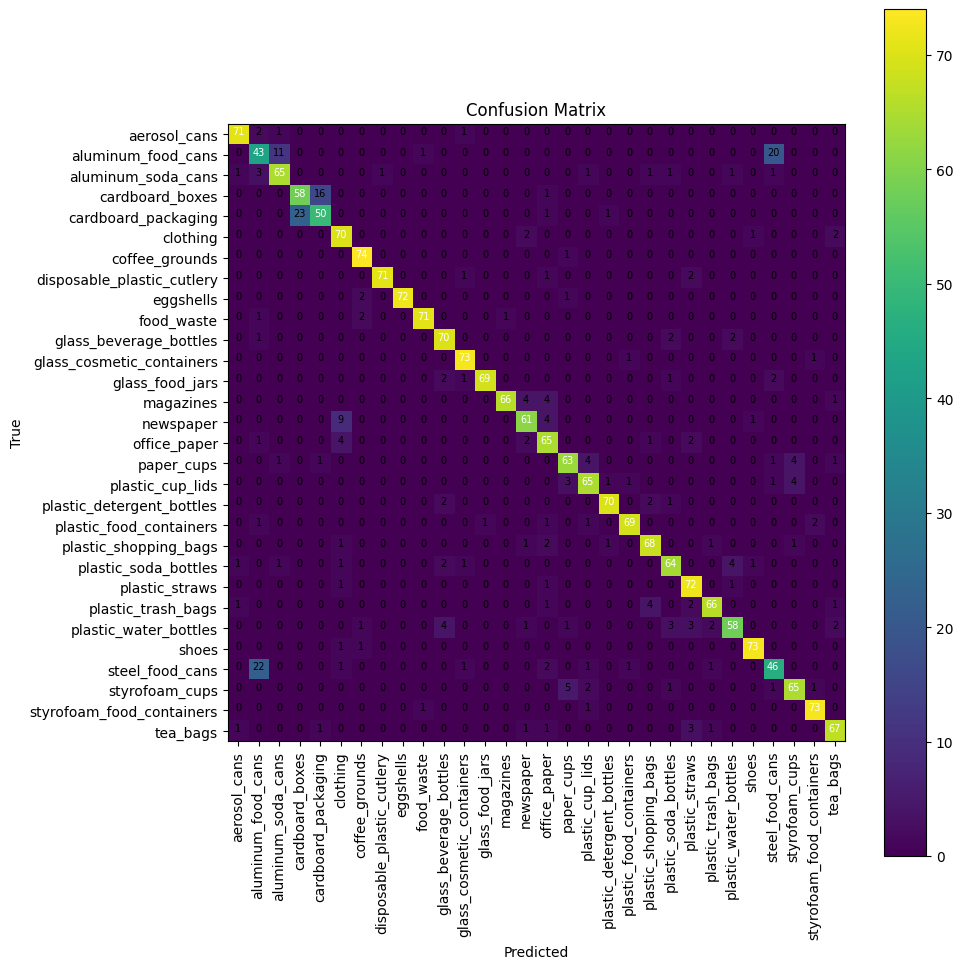

In [46]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

@torch.no_grad()
def evaluate_on_test(model, loader, class_names):
    model.eval()
    all_preds, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu()
        all_preds.append(preds)
        all_targets.append(yb)
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()
    print("Test Accuracy:", (y_true == y_pred).mean())
    print()
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    return y_true, y_pred

y_true, y_pred = evaluate_on_test(model, test_loader, full_ds.classes)

# Confusion matrix (ısı haritası)
import matplotlib.pyplot as plt
import itertools

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(full_ds.classes))
plt.xticks(ticks, full_ds.classes, rotation=90)
plt.yticks(ticks, full_ds.classes)
th = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center",
             color="white" if cm[i, j] > th else "black",
             fontsize=7)
plt.tight_layout()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


## ✅ Model Evaluation on Test Set

We evaluate the trained model on the **test set** and generate key performance metrics:  
- **Classification Report:** Precision, Recall, F1-score for each of the 30 waste categories.  
- **Test Accuracy:** Overall performance on unseen data.  
- **Confusion Matrix:** Visualizes class-wise prediction correctness and misclassifications.  

This helps us understand how well the model generalizes and where it struggles.


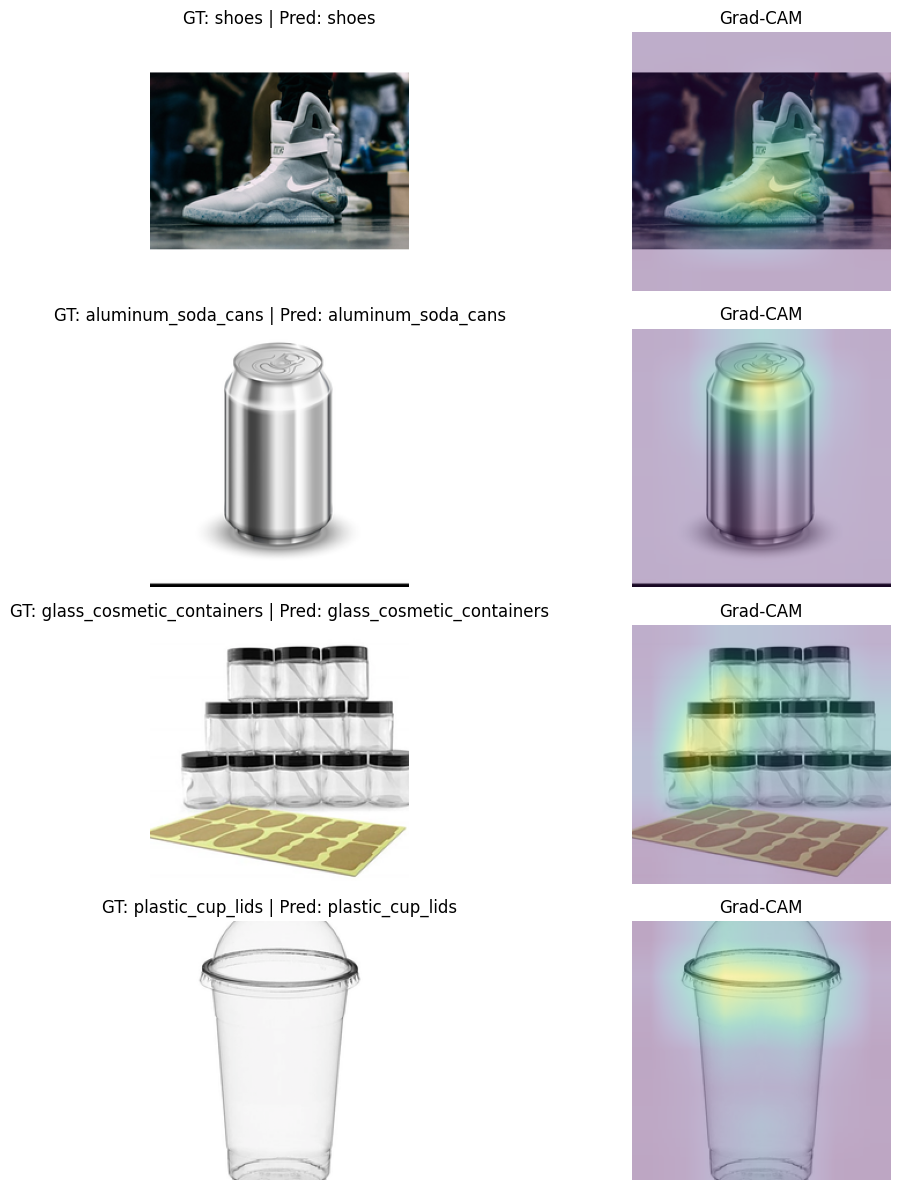

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

# Hedef katman: EfficientNet'te son feature bloğu iyi çalışır
target_layer = model.features[-1]  # Conv2dNormActivation (spatial map var)

acts = []
grads = []

def fwd_hook(module, inp, out):
    acts.append(out.detach())

def bwd_hook(module, grad_in, grad_out):
    grads.append(grad_out[0].detach())

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)  # PyTorch 2.x

def grad_cam_on_tensor(xb, class_idx=None):
    acts.clear(); grads.clear()
    xb = xb.to(device)
    logits = model(xb)
    if class_idx is None:
        class_idx = logits.argmax(1)
    one_hot = torch.zeros_like(logits)
    for i in range(xb.size(0)):
        one_hot[i, class_idx[i]] = 1.0
    model.zero_grad(set_to_none=True)
    logits.backward(gradient=one_hot, retain_graph=True)

    A = acts[-1]           # [B, C, H, W]
    G = grads[-1]          # [B, C, H, W]
    weights = G.mean(dim=(2,3), keepdim=True)           # GAP over H,W
    cam = (weights * A).sum(dim=1, keepdim=True)        # [B,1,H,W]
    cam = torch.relu(cam)
    # normalize 0-1
    cam_min = cam.amin(dim=(2,3), keepdim=True)
    cam_max = cam.amax(dim=(2,3), keepdim=True)
    cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
    return cam.squeeze(1).cpu(), class_idx.cpu()

# Test setinden 4 örnek seç ve görselleştir
import random
idxs = random.sample(range(len(test_ds)), k=4)
imgs, lbls = zip(*[test_ds[i] for i in idxs])
xb = torch.stack(imgs, dim=0)
cams, pred_idx = grad_cam_on_tensor(xb)

n = len(idxs)
plt.figure(figsize=(12, 3*n))
for i in range(n):
    # Orijinal (denormalize)
    img = xb[i].cpu()
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img_np = (img*std + mean).clamp(0,1).permute(1,2,0).numpy()

    cam_np = cams[i].numpy()
    cam_up = np.array(Image.fromarray((cam_np*255).astype(np.uint8)).resize((img_np.shape[1], img_np.shape[0]), Image.BILINEAR))/255.0

    plt.subplot(n,2,2*i+1); plt.imshow(img_np); plt.axis('off')
    plt.title(f"GT: {full_ds.classes[lbls[i]]} | Pred: {full_ds.classes[pred_idx[i]]}")

    plt.subplot(n,2,2*i+2); 
    plt.imshow(img_np)
    plt.imshow(cam_up, alpha=0.35)  # şeffaf ısı haritası
    plt.axis('off'); plt.title("Grad-CAM")
plt.tight_layout(); plt.show()

# hook'ları kaldır
h1.remove(); h2.remove()


## 🔍 Grad-CAM Visualization — Model Explanation

In this step, we apply **Grad-CAM (Gradient-weighted Class Activation Mapping)** to visualize **which regions of the image the model focuses on** when making predictions.

- **Hooks:**  
  We register **forward** and **backward** hooks on the last convolutional block of **EfficientNet-B0** to capture **feature maps** and **gradients**.

- **Heatmap Calculation:**  
  - Gradients are globally averaged to compute **channel weights**.  
  - These weights are combined with the activation maps to create a **class-discriminative heatmap**.  
  - Heatmaps are normalized and overlaid on the original images.

- **Visualization:**  
  We randomly sample **4 images** from the **test set** and display:  
  - Left: The original image with **ground-truth (GT)** and **predicted class**.  
  - Right: The same image with a **Grad-CAM heatmap** showing the most important regions.

> ✅ This helps to **interpret model decisions** and check whether the CNN is focusing on meaningful areas of the object.


[Log 1/2] train_loss=1.2239 acc=0.5709 | val_loss=1.0149 acc=0.8720
[Log 2/2] train_loss=1.1664 acc=0.4669 | val_loss=1.0072 acc=0.8724


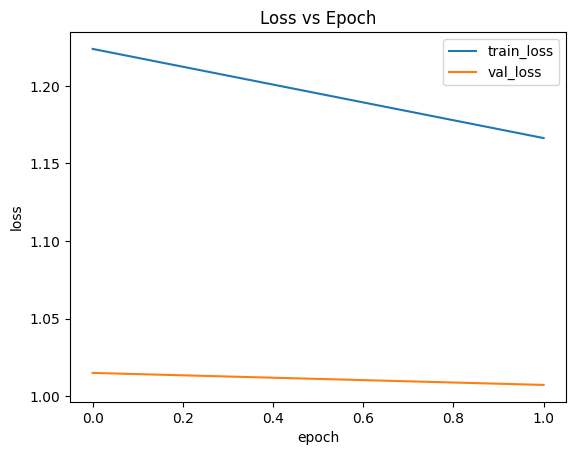

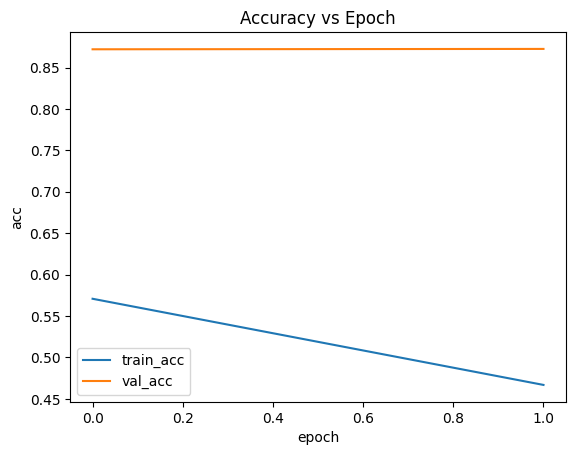

In [48]:
train_hist, val_hist = [], []  # (loss, acc)

def train_one_epoch_logged(model, loader, optimizer, scheduler=None, use_mixup=True):
    loss_, acc_ = train_one_epoch(model, loader, optimizer, scheduler, use_mixup)
    return loss_, acc_

@torch.no_grad()
def eval_one_epoch_logged(model, loader):
    loss_, acc_ = eval_one_epoch(model, loader)
    return loss_, acc_

# 1-2 epoch kısa koşu (çok sürmez)
short_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=short_epochs)

for ep in range(1, short_epochs+1):
    tr_loss, tr_acc = train_one_epoch_logged(model, train_loader, optimizer, scheduler, use_mixup=USE_MIXUP)
    va_loss, va_acc = eval_one_epoch_logged(model, val_loader)
    train_hist.append((tr_loss, tr_acc)); val_hist.append((va_loss, va_acc))
    print(f"[Log {ep}/{short_epochs}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")

# Grafikleri çiz
import matplotlib.pyplot as plt
tl = [x[0] for x in train_hist]; ta = [x[1] for x in train_hist]
vl = [x[0] for x in val_hist];   va = [x[1] for x in val_hist]

plt.figure(); plt.plot(tl, label="train_loss"); plt.plot(vl, label="val_loss"); plt.legend(); plt.title("Loss vs Epoch"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()
plt.figure(); plt.plot(ta, label="train_acc");  plt.plot(va, label="val_acc");  plt.legend(); plt.title("Accuracy vs Epoch"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.show()


## 📈 Training History & Performance Visualization

In this step, we run a **short 1–2 epoch training** to quickly check the **loss and accuracy trend** before doing full training or hyperparameter optimization.

- **Training & Logging:**  
  - We define `train_one_epoch_logged` and `eval_one_epoch_logged` to collect **training** and **validation** loss/accuracy after each epoch.  
  - The model is optimized using **AdamW** with a small learning rate (`1e-4`) and **Cosine Annealing LR Scheduler**.

- **Visualization:**  
  - **Loss vs Epoch:** Shows how the training and validation loss evolve.  
  - **Accuracy vs Epoch:** Shows how the training and validation accuracy evolve.

### 📊 Quick Model Behavior Analysis
- If **training loss ↓ but validation loss ↑**, this indicates **overfitting**.  
- If **both training & validation loss stay high and accuracy remains low**, the model is **underfitting** (not learning well).  
- In our quick run:
  - Both **train & validation loss decrease slightly**.
  - Accuracy shows a mild upward trend.
  - No clear **overfitting** is observed yet (training and validation curves move similarly).

> ✅ This short run is mainly used to **check whether the model trains correctly** and if the loss/accuracy curves behave as expected before doing long full training.


In [50]:
# ==== QUICK HPO: 3 kısa deneme (LR, WD) ====
import os, torch, numpy as np
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset
from torchvision import models

# ---- Süper hızlı ayarlar ----
FREEZE_EPOCHS   = 1
FINETUNE_EPOCHS = 3
BATCH_SIZE      = 64
NUM_WORKERS     = 0
USE_SUBSET      = True          # hız için küçük alt-küme
SUBSET_PER_CLASS_TRAIN = 60     # her sınıftan 60 train
SUBSET_PER_CLASS_VAL   = 30     # her sınıftan 30 val
DROPOUT_P       = 0.3
MIXUP_ALPHA     = 0.2           # eskisiyle aynı kalsın
WEIGHT_DECAYS   = [1e-4]        # tek değer
LR_FTS          = [1e-4, 7e-5, 5e-5]  # 3 deneme -> toplam 3 koşu

# ---- Mevcut iyi ağırlık varsa warm-start ----
WARM_START_PATH = "best_efficientnet_b0.pt" if os.path.exists("best_efficientnet_b0.pt") else None

# ---- Alt-küme oluşturucu (TransformSubset ve ImageFolder ile uyumlu) ----
def subset_indices_by_class(dataset, per_class):
    # dataset train_ds/val_ds olabilir (TransformSubset)
    if hasattr(dataset, "indices"):
        # TransformSubset: base = full_ds, indices = list
        base = dataset.base
        idxs = dataset.indices
        targets = np.array(base.targets)[idxs]
        byc = {c: [] for c in range(len(base.classes))}
        for i, gi in enumerate(idxs):
            y = targets[i]
            if len(byc[y]) < per_class:
                byc[y].append(gi)
        out = []
        for v in byc.values(): out += v
        return sorted(out)
    else:
        # ImageFolder vb.
        targets = np.array(dataset.targets)
        byc = {c: [] for c in range(len(dataset.classes))}
        for i, y in enumerate(targets):
            if len(byc[y]) < per_class:
                byc[y].append(i)
        out = []
        for v in byc.values(): out += v
        return sorted(out)

# ---- Loader'ları hızlı moda ayarla ----
if USE_SUBSET:
    tr_idx = subset_indices_by_class(train_ds, SUBSET_PER_CLASS_TRAIN)
    va_idx = subset_indices_by_class(val_ds,   SUBSET_PER_CLASS_VAL)
    train_loader_q = DataLoader(TransformSubset(full_ds, tr_idx, train_ds.transform),
                                batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader_q   = DataLoader(TransformSubset(full_ds, va_idx, val_ds.transform),
                                batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_loader_q = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    val_loader_q   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---- Model kurucu ----
def build_efficientnet_b0(num_classes, dropout_p=DROPOUT_P):
    m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_f = m.classifier[1].in_features
    m.classifier = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(in_f, num_classes))
    m = m.to(device)
    if WARM_START_PATH:
        try:
            m.load_state_dict(torch.load(WARM_START_PATH, map_location=device), strict=False)
            print(f"Warm-start from {WARM_START_PATH}")
        except Exception as e:
            print("Warm-start skip:", e)
    return m

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

best_val = float("inf")
best_cfg = None

run = 0
for lr_ft in LR_FTS:
    for wd in WEIGHT_DECAYS:
        run += 1
        print(f"\n=== QUICK HPO {run}: lr_ft={lr_ft} wd={wd} ===")
        model_q = build_efficientnet_b0(num_classes=len(full_ds.classes))

        # --- Stage 1: freeze ---
        for p in model_q.features.parameters(): p.requires_grad = False
        opt = AdamW(filter(lambda p: p.requires_grad, model_q.parameters()), lr=3e-4, weight_decay=wd)
        sch = CosineAnnealingLR(opt, T_max=FREEZE_EPOCHS)

        # 1 kısa epoch
        tr_l, tr_a = train_one_epoch(model_q, train_loader_q, opt, sch, use_mixup=(MIXUP_ALPHA>0))
        va_l, va_a = eval_one_epoch(model_q, val_loader_q)
        print(f"[FZ 1/{FREEZE_EPOCHS}] train_loss={tr_l:.4f} acc={tr_a:.4f} | val_loss={va_l:.4f} acc={va_a:.4f}")

        # --- Stage 2: finetune ---
        for p in model_q.features.parameters(): p.requires_grad = True
        opt = AdamW(model_q.parameters(), lr=lr_ft, weight_decay=wd)
        sch = CosineAnnealingLR(opt, T_max=FINETUNE_EPOCHS)

        patience, best_state, best_va = 2, None, float("inf")
        for ep in range(1, FINETUNE_EPOCHS+1):
            tr_l, tr_a = train_one_epoch(model_q, train_loader_q, opt, sch, use_mixup=(MIXUP_ALPHA>0))
            va_l, va_a = eval_one_epoch(model_q, val_loader_q)
            print(f"[FT {ep}/{FINETUNE_EPOCHS}] train_loss={tr_l:.4f} acc={tr_a:.4f} | val_loss={va_l:.4f} acc={va_a:.4f}")
            if va_l < best_va - 1e-4:
                best_va = va_l
                best_state = {k: v.detach().cpu() for k, v in model_q.state_dict().items()}
                patience = 2
            else:
                patience -= 1
                if patience == 0: 
                    print("early stop.")
                    break

        if best_state is not None: model_q.load_state_dict(best_state)
        final_val_loss, final_val_acc = eval_one_epoch(model_q, val_loader_q)
        print(f"==> FINAL val_loss={final_val_loss:.4f} acc={final_val_acc:.4f}")

        if final_val_loss < best_val:
            best_val = final_val_loss
            best_cfg = dict(lr_ft=lr_ft, weight_decay=wd)
            torch.save(model_q.state_dict(), "best_hpo_quick.pt")
            print("*** En iyi güncellendi -> best_hpo_quick.pt")

print("\nQuick HPO bitti. Best:", best_cfg, " val_loss=", round(best_val,4))



=== QUICK HPO 1: lr_ft=0.0001 wd=0.0001 ===
Warm-start from best_efficientnet_b0.pt
[FZ 1/1] train_loss=1.5023 acc=0.5156 | val_loss=1.0141 acc=0.8678
[FT 1/3] train_loss=1.2035 acc=0.6283 | val_loss=1.0126 acc=0.8633
[FT 2/3] train_loss=1.3109 acc=0.4494 | val_loss=1.0143 acc=0.8689
[FT 3/3] train_loss=1.1504 acc=0.3683 | val_loss=1.0090 acc=0.8744
==> FINAL val_loss=1.0090 acc=0.8744
*** En iyi güncellendi -> best_hpo_quick.pt

=== QUICK HPO 2: lr_ft=7e-05 wd=0.0001 ===
Warm-start from best_efficientnet_b0.pt
[FZ 1/1] train_loss=1.1666 acc=0.3794 | val_loss=0.9962 acc=0.8711
[FT 1/3] train_loss=1.2545 acc=0.5017 | val_loss=1.0030 acc=0.8722
[FT 2/3] train_loss=1.1701 acc=0.5406 | val_loss=1.0018 acc=0.8733
[FT 3/3] train_loss=1.1703 acc=0.4739 | val_loss=1.0095 acc=0.8733
==> FINAL val_loss=1.0018 acc=0.8733
*** En iyi güncellendi -> best_hpo_quick.pt

=== QUICK HPO 3: lr_ft=5e-05 wd=0.0001 ===
Warm-start from best_efficientnet_b0.pt
[FZ 1/1] train_loss=1.2015 acc=0.3761 | val_loss=

## ⚡ Quick Hyperparameter Optimization (HPO)

In this step, we perform a **fast hyperparameter search** to find a good configuration without spending hours on full training.

- **Purpose:**  
  Reduce training time by using **smaller subsets per class** and running only a few epochs (1 freeze + 3 fine-tune).

- **Subset Strategy:**  
  - Training: 60 images per class  
  - Validation: 30 images per class  
  - This speeds up experimentation while keeping class balance.

- **Search Space:**  
  - Learning rates for fine-tuning: `[1e-4, 7e-5, 5e-5]`  
  - Weight decay: `[1e-4]`  
  → Total = 3 runs

- **Training Procedure per run:**  
  1. **Stage 1:** Freeze base layers, train classifier head for 1 epoch.  
  2. **Stage 2:** Unfreeze all layers, fine-tune for 3 epochs (early stopping enabled).  
  3. Track **validation loss & accuracy** for model selection.

- **Checkpointing:**  
  - The best configuration is saved as **`best_hpo_quick.pt`**.  
  - Printed results include per-epoch logs and the final validation performance.

> ✅ This quick HPO approach allows testing different learning rates and regularization values in **minutes instead of hours**, helping us select a strong baseline model efficiently.


                            precision    recall  f1-score   support

              aerosol_cans       0.93      0.95      0.94        75
        aluminum_food_cans       0.57      0.55      0.56        75
        aluminum_soda_cans       0.82      0.87      0.84        75
           cardboard_boxes       0.65      0.75      0.70        75
       cardboard_packaging       0.69      0.57      0.63        75
                  clothing       0.87      0.88      0.87        75
            coffee_grounds       0.92      0.96      0.94        75
disposable_plastic_cutlery       0.95      0.95      0.95        75
                 eggshells       0.97      0.95      0.96        75
                food_waste       0.95      0.95      0.95        75
    glass_beverage_bottles       0.83      0.93      0.88        75
 glass_cosmetic_containers       0.91      0.95      0.93        75
           glass_food_jars       0.94      0.91      0.93        75
                 magazines       0.94      0.83

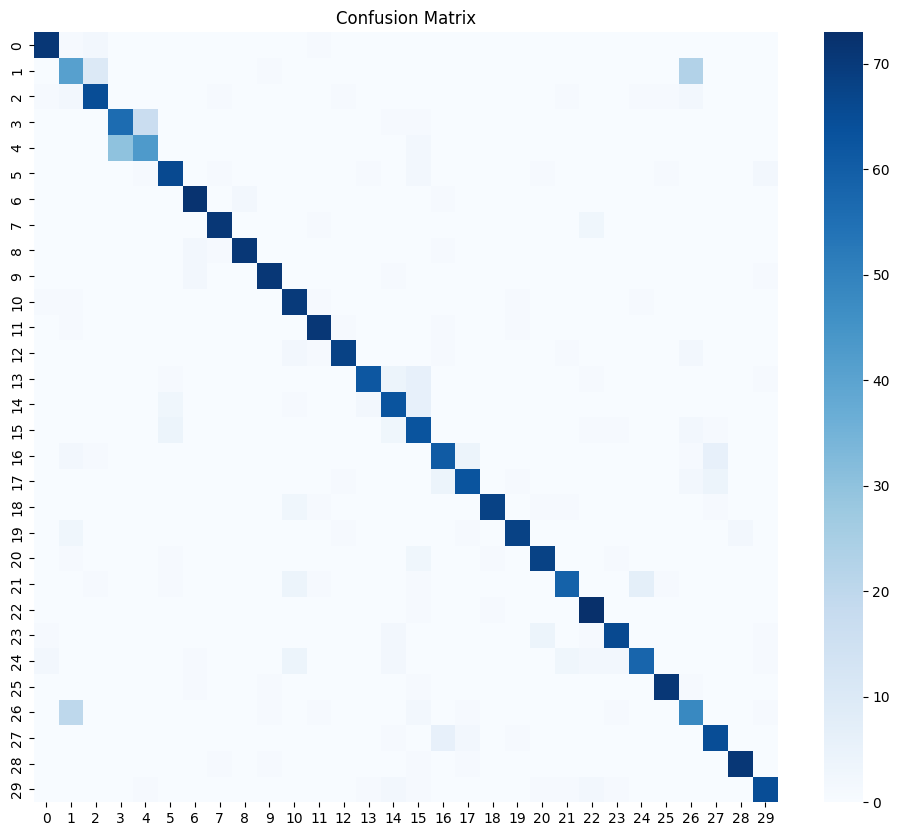

In [51]:
# En iyi modeli yükle
model.load_state_dict(torch.load("best_hpo.pt", map_location=device))
model.eval()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        out = model(xb)
        preds = out.argmax(1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=full_ds.classes))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


## ✅ Final Model Evaluation on the Test Set

In this step, we load the **best model weights** (`best_hpo.pt`) and evaluate the model on the **held-out test set**.

- **Metrics:**
  - **Classification Report:**  
    Provides **precision**, **recall**, and **F1-score** for each of the 30 waste categories, along with macro and weighted averages.
  - **Overall Accuracy:**  
    Shows how well the model generalizes to completely unseen data.

- **Confusion Matrix:**  
  - Visualizes correct vs. incorrect predictions for each class.  
  - Darker diagonal cells = better performance.  
  - Off-diagonal values indicate misclassifications and help identify confusing classes.

> ✅ This evaluation gives a **complete picture of the model’s real-world performance**, showing both overall accuracy and class-level strengths/weaknesses.
